#### <strong>第二次作品：影像矩陣的 SVD 實驗</strong>
學號：711333104

姓名：林子齊
<hr>

 <font color=skyblue>作品目標</font>：
 <hr>

第 1 題：

以數字圖像為例，挑選某一個特定數字的所有影像，對其進行 Rank-q approximation，以取得與原圖像相同大小與張數的近似影像。透過實作 Rank-q approximation，本題比較兩種常用的矩陣分解方法（PCA 與 SVD）在數字影像資料上的應用效果，並設定 $q = 1, 3, 5, \dots, 29$，觀察不同q值下的近似影像品質如何變化。藉此深入理解 PCA 與 SVD 的理論基礎與實作差異，並強化對資料降維與影像重建技術的掌握。

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import pickle
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
data_file = 'data/mnist_digits_784.pkl'
# Check if data file exists
if os.path.isfile(data_file):
    # Load data from file
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
else:
    # Fetch data from internet
    data = fetch_openml('mnist_784', version=1, parser='auto')
    # Save data to file
    with open(data_file, 'wb') as f:
        pickle.dump(data, f)
# Print the keys
print(data.keys())
# Print the shape of the data
print(data.data.shape)
print(data.target.shape)

# description of the data
print(data.DESCR)

# Print the unique labels
print(np.unique(data.target))
# Print the first few data points
print(data.data[:5])
# Extract data and labels
X, y = np.array(data.data).T, np.array(data.target).astype('int')
# Split data into training and test sets
# X_train, X_test = data.data[:60000], data.data[60000:]
# y_train, y_test = data.target[:60000], data.target[60000:]

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
(70000, 784)
(70000,)
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain 

In [3]:
digit = 3
digit_indices = np.where(y == digit)[0]
X_digit = X[:, digit_indices].T  # 每一欄為一張圖，總共 N 張
print(X_digit.shape)  # 應為 (N, 784)


(7141, 784)


In [ ]:
def pca_rank_q_approx(X, q):
    pca = PCA(n_components=q)
    X_pca = pca.fit_transform(X)           # (N, q)
    X_recon = pca.inverse_transform(X_pca) # (N, 784)
    return X_recon


In [15]:
def pca_no_mean(X, q):
    pca = PCA(n_components=q)
    X_centered = X - pca.fit(X).mean_
    X_proj = X_centered @ pca.components_.T
    X_recon = X_proj @ pca.components_   # ❌ 沒有加回 mean
    return X_recon

In [5]:
def svd_rank_q_approx(X, q):
    U, S, VT = np.linalg.svd(X, full_matrices=False)  # X: (N, 784)
    U_q = U[:, :q]                  # (N, q)
    S_q = np.diag(S[:q])            # (q, q)
    VT_q = VT[:q, :]                # (q, 784)
    X_recon = U_q @ S_q @ VT_q      # (N, 784)
    return X_recon


In [ ]:
def montage(A, m, n):
    '''
    A: (p x N) 每欄為一張展平圖像（例如 784 x N）
    '''
    sz = int(np.sqrt(A.shape[0]))  # 假設為方形圖
    M = np.zeros((m * sz, n * sz))
    for i in range(m):
        for j in range(n):
            M[i*sz:(i+1)*sz, j*sz:(j+1)*sz] = A[:, i*n + j].reshape(sz, sz)
    return M

In [13]:
def plot_montage_by_rank(X_original, X_list, q_list, num_images=20):
    montage_rows = []
    montage_rows.append(montage(X_original[:num_images].T, 1, num_images))  # 原圖
    for Xq in X_list:
        montage_rows.append(montage(Xq[:num_images].T, 1, num_images))      # 重建圖
    full_montage = np.vstack(montage_rows)
    plt.figure(figsize=(num_images // 2, len(q_list) + 1))
    plt.imshow(full_montage, cmap='gray')
    plt.axis('off')
    plt.title("Top: Original | Below: Rank-q Approximations")
    plt.show()

PCA Approximation for digit = 3


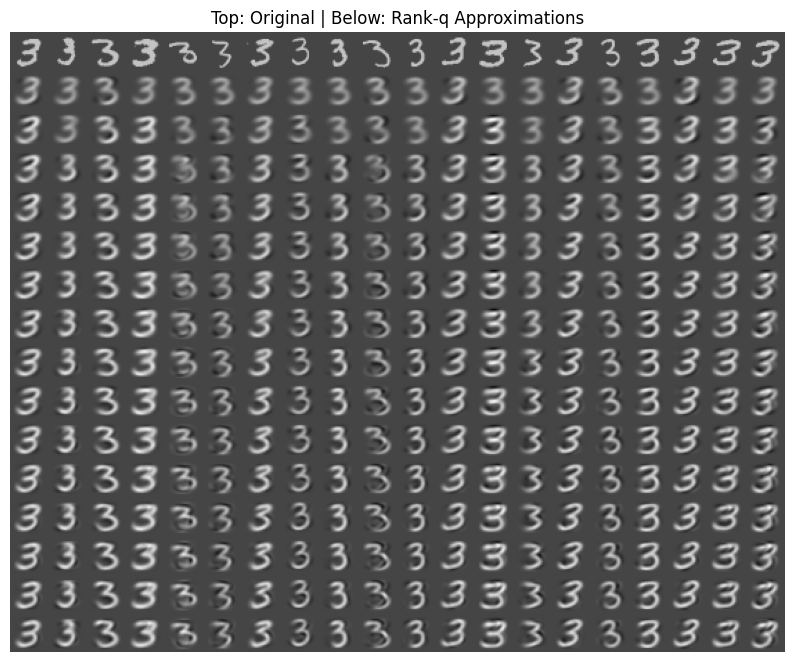

SVD Approximation for digit = 3


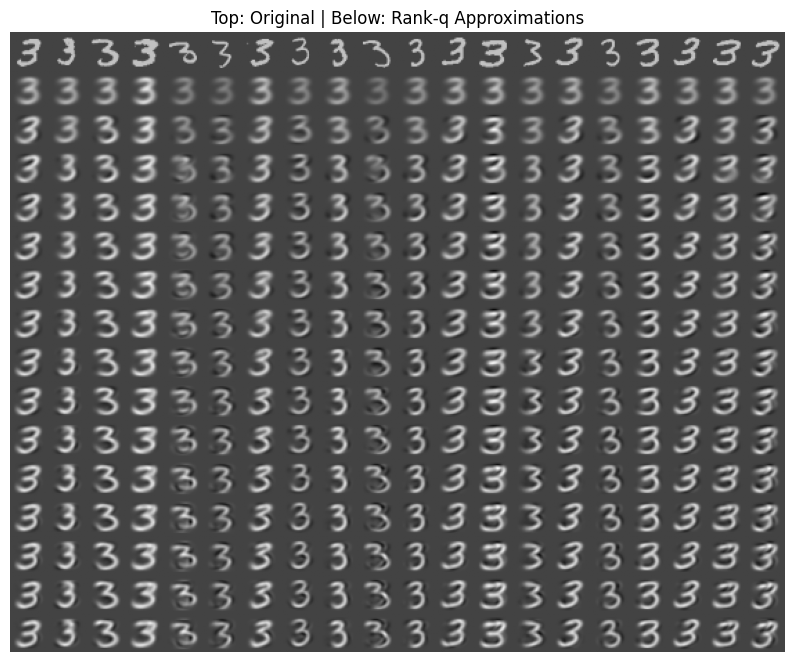

In [14]:
# === 7. 主程式：執行重建與畫圖 ===
q_values = list(range(1, 30, 2))  # q = 1, 3, ..., 29

# PCA & SVD 重建
X_pca_list = [pca_rank_q_approx(X_digit, q) for q in q_values]
X_svd_list = [svd_rank_q_approx(X_digit, q) for q in q_values]

# 畫圖（PCA）
print("PCA Approximation for digit =", digit)
plot_montage_by_rank(X_digit, X_pca_list, q_values)

# 畫圖（SVD）
print("SVD Approximation for digit =", digit)
plot_montage_by_rank(X_digit, X_svd_list, q_values)

PCA Approximation (with mean) for digit = 3


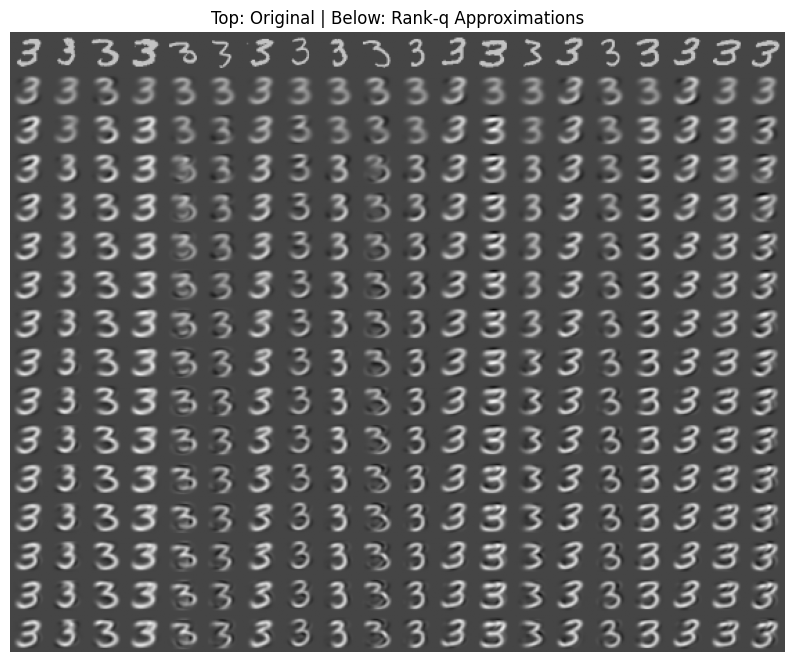

PCA Approximation (no mean) for digit = 3


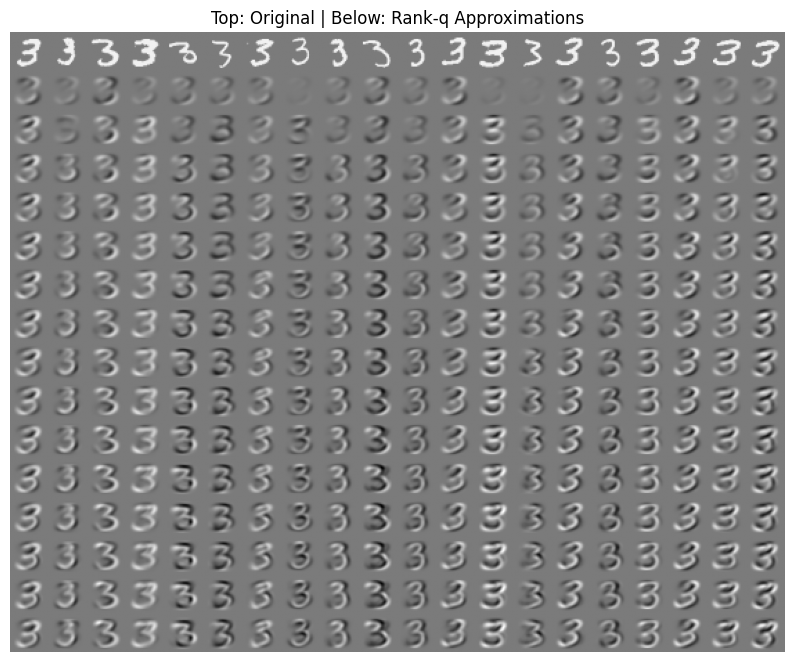

SVD Approximation for digit = 3


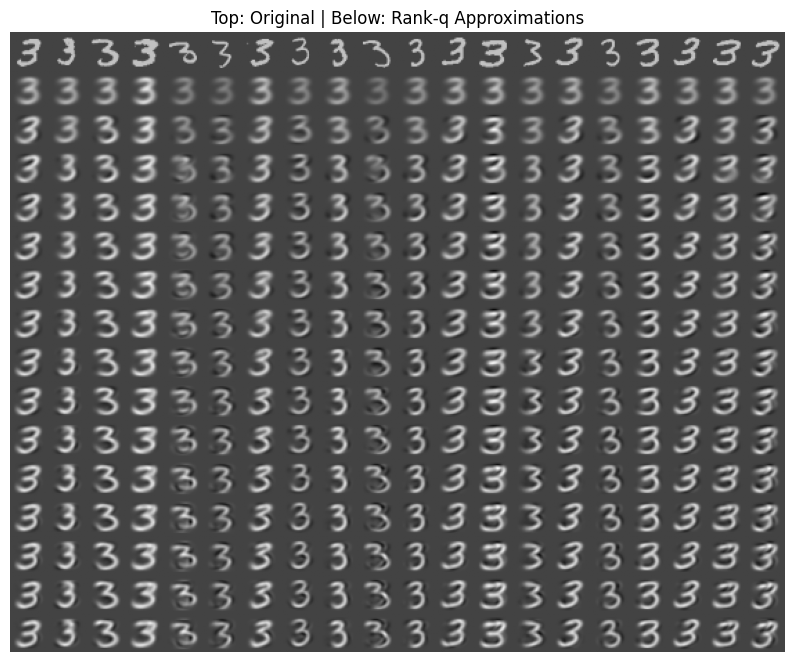

In [18]:
# === 7. 主程式：執行重建與畫圖 ===
q_values = list(range(1, 30, 2))  # q = 1, 3, ..., 29

# PCA 有加回 mean
X_pca_list = [pca_rank_q_approx(X_digit, q) for q in q_values]

# PCA 沒有加回 mean（手動做）
X_pca_dark_list = [pca_no_mean(X_digit, q) for q in q_values]

# SVD 重建
X_svd_list = [svd_rank_q_approx(X_digit, q) for q in q_values]

# 畫圖（PCA：加回 mean）
print("PCA Approximation (with mean) for digit =", digit)
plot_montage_by_rank(X_digit, X_pca_list, q_values)

# 畫圖（PCA：沒加回 mean）
print("PCA Approximation (no mean) for digit =", digit)
plot_montage_by_rank(X_digit, X_pca_dark_list, q_values)

# 畫圖（SVD）
print("SVD Approximation for digit =", digit)
plot_montage_by_rank(X_digit, X_svd_list, q_values)
